In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('../../Data/StressLevelDataset.csv')
print(df)

      anxiety_level  self_esteem  mental_health_history  depression  headache  \
0                14           20                      0          11         2   
1                15            8                      1          15         5   
2                12           18                      1          14         2   
3                16           12                      1          15         4   
4                16           28                      0           7         2   
...             ...          ...                    ...         ...       ...   
1095             11           17                      0          14         3   
1096              9           12                      0           8         0   
1097              4           26                      0           3         1   
1098             21            0                      1          19         5   
1099             18            6                      1          15         3   

      blood_pressure  sleep

In [3]:
X = df.drop('stress_level', axis=1)
y = df['stress_level']

In [4]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_scaled, y_train)
svm = SVC(kernel='rbf', probability=True).fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_pred_svm = svm.predict(X_test_scaled)

print("Classification Report (using KNN): \n", classification_report(y_test, y_pred_knn))
print("Classification Report (using SVM): \n", classification_report(y_test, y_pred_svm))

Classification Report (using KNN): 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84        76
           1       0.86      0.89      0.87        73
           2       0.88      0.85      0.86        71

    accuracy                           0.86       220
   macro avg       0.86      0.86      0.86       220
weighted avg       0.86      0.86      0.86       220

Classification Report (using SVM): 
               precision    recall  f1-score   support

           0       0.79      0.88      0.83        76
           1       0.91      0.85      0.88        73
           2       0.88      0.83      0.86        71

    accuracy                           0.85       220
   macro avg       0.86      0.85      0.86       220
weighted avg       0.86      0.85      0.86       220



In [6]:
from sklearn.model_selection import GridSearchCV

knn_param_grid = {
    'n_neighbors': [7, 9, 11, 13, 15],
    'weights': ['uniform'],
    'metric': ['manhattan']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)

print(f"Best KNN Params: {grid_knn.best_params_}")
print(f"Best KNN Accuracy: {grid_knn.best_score_:.2%}")

Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best KNN Accuracy: 87.27%


In [7]:
svm_param_grid = {
    'C': [0.1, 1,5], 
    'gamma' : [0.001, 0.0001],
    'kernel' : ['rbf'],
}

grid_svm = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)

print(f"Best SVM Params: {grid_svm.best_params_}")
print(f"Best SVM Accuracy: {grid_svm.best_score_:.2%}")

Best SVM Params: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
Best SVM Accuracy: 87.16%


In [8]:
train_acc = grid_svm.score(X_train_scaled, y_train)
test_acc = grid_svm.score(X_test_scaled, y_test)

print(f"Training Accuracy: {train_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")

Training Accuracy: 90.68%
Test Accuracy: 89.09%


In [9]:
train_acc = grid_knn.score(X_train_scaled, y_train)
test_acc = grid_knn.score(X_test_scaled, y_test)

print(f"Training Accuracy: {train_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")

Training Accuracy: 90.80%
Test Accuracy: 87.73%


In [10]:
from sklearn.ensemble import VotingClassifier

svm_best = SVC(C=5, gamma=0.001, kernel='rbf', probability=True)
knn_best = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='manhattan')

# Create the Ensemble
voting_clf = VotingClassifier(
    estimators=[('svm', svm_best), ('knn', knn_best)],
    voting='soft' # Takes the average of probabilities
)

# Fit and Evaluate
voting_clf.fit(X_train_scaled, y_train)

print(f"Ensemble Training Accuracy: {voting_clf.score(X_train_scaled, y_train):.2%}")
print(f"Ensemble Test Accuracy: {voting_clf.score(X_test_scaled, y_test):.2%}")

Ensemble Training Accuracy: 91.25%
Ensemble Test Accuracy: 88.64%


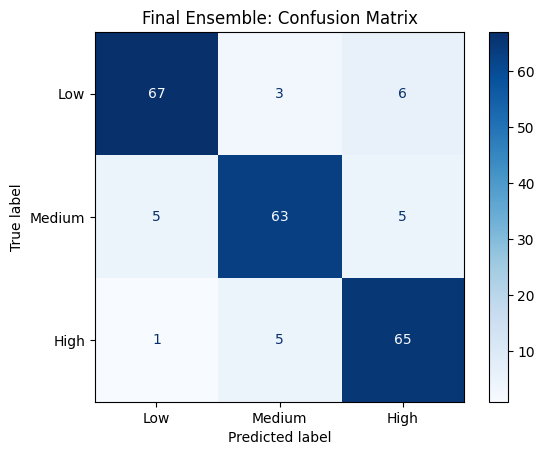

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = voting_clf.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])

disp.plot(cmap='Blues')
plt.title("Final Ensemble: Confusion Matrix")
plt.show()

In [12]:
import joblib

# Save the ensemble model
joblib.dump(voting_clf, 'stress_model.pkl')

# Save the scaler (Crucial: the React data must be scaled the same way!)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

Top 6 Features for your React App: ['bullying', 'future_career_concerns', 'anxiety_level', 'depression', 'headache', 'extracurricular_activities']


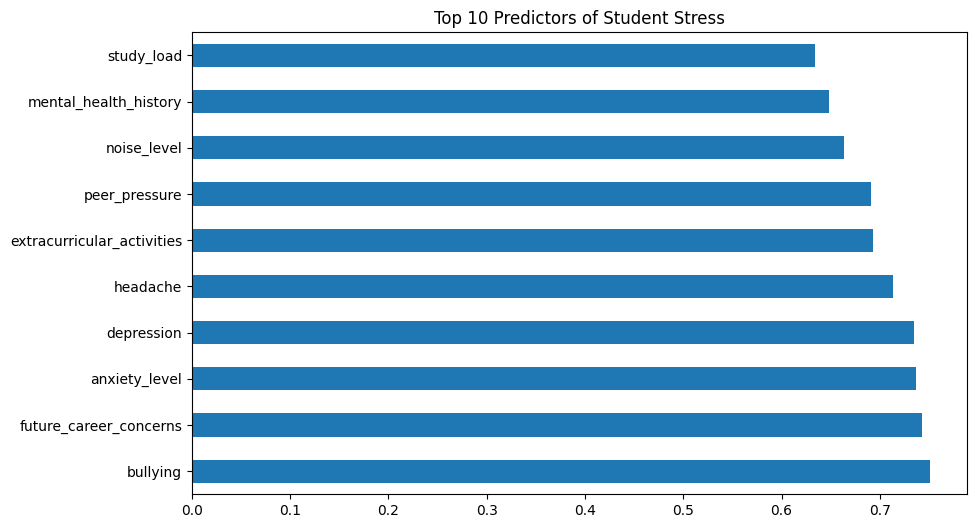

In [ ]:
import numpy as np

correlations = df.corr()['stress_level'].sort_values(ascending=False)

top_6_features = correlations.index[1:7].tolist()
print("Top 6 Features for your React App:", top_6_features)

plt.figure(figsize=(10,6))
correlations[1:11].plot(kind='barh')
plt.title("Top 10 Predictors of Student Stress")
plt.show()

In [19]:
X_small = df[top_6_features]
y = df['stress_level']

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_small, y, random_state=42, test_size=0.2)

scaler_small = StandardScaler()
X_train_scaled_sm = scaler_small.fit_transform(X_train_sm)
X_test_scaled_sm = scaler_small.transform(X_test_sm)

svm_best = SVC(C=5, gamma=0.001, kernel='rbf', probability=True).fit(X_train_scaled_sm, y_train)
knn_best = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='manhattan').fit(X_train_scaled_sm, y_train)

voting_clf_small = VotingClassifier(
    estimators=[('svm', svm_best), ('knn', knn_best)],
    voting='soft'
)
voting_clf_small.fit(X_train_scaled_sm, y_train)

print(f"Train Accuracy (6 Features): {voting_clf_small.score(X_train_scaled_sm, y_train):.2%}")
print(f"Test Accuracy (6 Features): {voting_clf_small.score(X_test_scaled_sm, y_test):.2%}")

joblib.dump(voting_clf_small, 'stress_model_small.pkl')
joblib.dump(scaler_small, 'scaler_small.pkl')

Train Accuracy (6 Features): 88.75%
Test Accuracy (6 Features): 88.64%


['scaler_small.pkl']

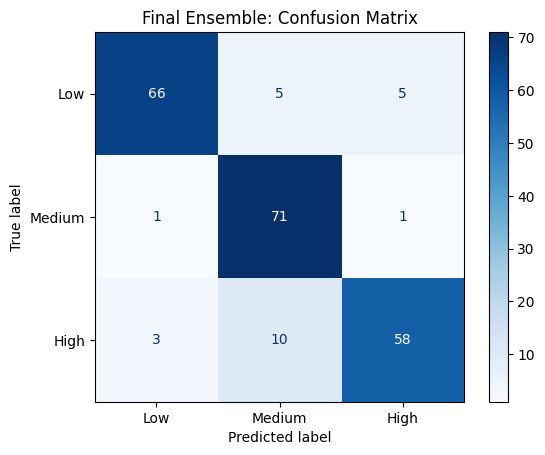

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = voting_clf_small.predict(X_test_scaled_sm)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])

disp.plot(cmap='Blues')
plt.title("Final Ensemble: Confusion Matrix")
plt.show()